In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
print(keras.__version__)

3.0.4


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv('lenta_40k.csv')

In [5]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [7]:
len(vocab)

354611

In [8]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [9]:
len(filtered_vocab)

24091

In [10]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [11]:
id2word = {i:word for word, i in word2id.items()}

In [12]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [13]:
MAX_LEN = max(len(x) for x in X)

In [14]:
MEAN_LEN = np.median([len(x) for x in X])

In [15]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [16]:
MAX_LEN = int(MEAN_LEN + 30)

In [17]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [18]:
X.shape

(44356, 200)

In [19]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [20]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [21]:
len(label2id)

19

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [46]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [24]:
# модель №1
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

conv1 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
mean = keras.layers.Flatten()(conv1)
dense = keras.layers.Dense(50, activation='relu')(mean)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.F1Score(average='weighted', name='f1')])

In [25]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=50,
         callbacks=[checkpoint, early_stop])

Epoch 1/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - f1: 0.1132 - loss: 2.6171
Epoch 1: val_f1 improved from -inf to 0.23306, saving model to model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - f1: 0.1149 - loss: 2.6063 - val_f1: 0.2331 - val_loss: 1.9824
Epoch 2/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - f1: 0.3237 - loss: 1.8143
Epoch 2: val_f1 improved from 0.23306 to 0.52807, saving model to model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - f1: 0.3271 - loss: 1.8064 - val_f1: 0.5281 - val_loss: 1.3570
Epoch 3/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - f1: 0.6184 - loss: 1.1070
Epoch 3: val_f1 improved from 0.52807 to 0.68561, saving model to model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - f1: 0.6202 - loss: 1.1027 - val_f1: 0.6856 - val_loss: 1.0191
Epoch 4/50
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - f1: 0.7751 - loss: 0.6885
Epoch 4: val_f1 improved from 0.68561 to 0.72497, saving model to model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms

dict_keys(['f1', 'loss', 'val_f1', 'val_loss'])


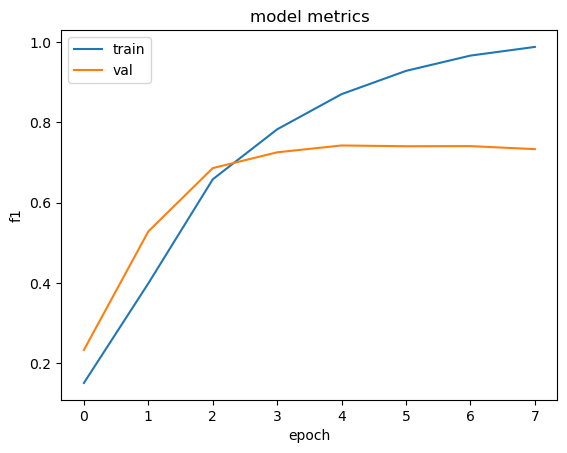

In [26]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model metrics')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# модель №2

In [ ]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.001, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [47]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

conv1 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=32, strides=2)(conv1)
pool = keras.layers.AveragePooling1D(pool_size=10)(conv2)
                            
mean = keras.layers.Flatten()(pool)
dense = keras.layers.Dense(60, activation='relu')(mean)
dropout = keras.layers.Dropout(0.3)(dense)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(dropout)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.F1Score(average='weighted', name='f1')])

In [48]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1500,
          epochs=50,
        callbacks=[checkpoint, early_stop])

Epoch 1/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - f1: 0.1103 - loss: 2.8412
Epoch 1: val_f1 improved from -inf to 0.13286, saving model to model.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - f1: 0.1113 - loss: 2.8306 - val_f1: 0.1329 - val_loss: 2.3641
Epoch 2/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - f1: 0.1398 - loss: 2.3709
Epoch 2: val_f1 improved from 0.13286 to 0.21398, saving model to model.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - f1: 0.1409 - loss: 2.3667 - val_f1: 0.2140 - val_loss: 2.0321
Epoch 3/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - f1: 0.2604 - loss: 1.9955
Epoch 3: val_f1 improved from 0.21398 to 0.41897, saving model to model.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - f1: 0.2636 - loss: 1.9863 - val_f1: 0.4190 - val_loss: 1.5180
Epoch 4/50
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - f1: 0.4512 - loss: 1.4655
Epoch 4: val_f1 improved from 0.41897 to 0.55633, saving model to model.weights.h5
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms

dict_keys(['f1', 'loss', 'val_f1', 'val_loss'])


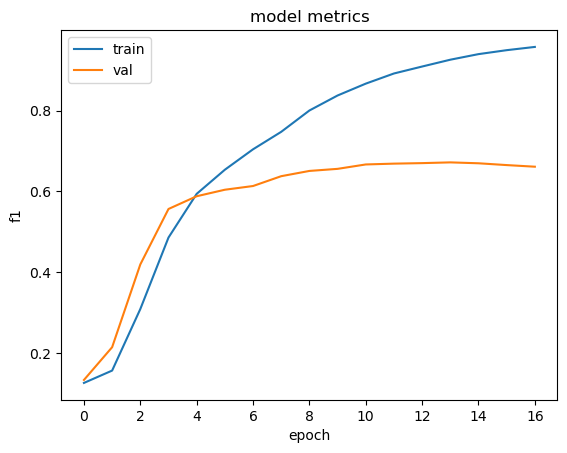

In [50]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model metrics')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
# модель №3
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

convs = []

for ks in [3,4,5,7,10]:
    dropout1 = keras.layers.Dropout(0.1)(embeddings)
    conv1 = keras.layers.Conv1D(kernel_size=2, filters=32, padding='same', strides=1)(dropout1) 
    pool1 = keras.layers.AveragePooling1D(pool_size=3, padding="same")(conv1) 
    conv2 = keras.layers.Conv1D(kernel_size=3, filters=32, padding='same', strides=1)(pool1) 
    pool2 = keras.layers.AveragePooling1D(pool_size=5, padding="same")(conv2) 
    conv3 = keras.layers.Conv1D(kernel_size=4, filters=32, padding='same', strides=1, 
                              kernel_regularizer='l2', activation='relu')(pool2) 
    pool3 = keras.layers.AveragePooling1D(pool_size=7, padding="same")(conv3) 
    dropout2 = keras.layers.Dropout(0.3)(pool3) 
    dense1 = keras.layers.Dense(50, activation='relu', kernel_regularizer='l2')(dropout2) 

    convs.append(dense1)

concat = keras.layers.concatenate(convs, axis=2)

conv4 = keras.layers.Conv1D(kernel_size=ks, filters=32, strides=2, padding="same")(concat) 
pool4 = keras.layers.AveragePooling1D(pool_size=4, padding="same")(conv4) 

dropout3 = keras.layers.Dropout(0.2)(pool4) 
mean = keras.layers.Flatten()(dropout3) 

dense2 = keras.layers.Dense(70, activation='relu', kernel_regularizer='l2')(mean) 
dropout4 = keras.layers.Dropout(0.3)(dense2) 

outputs = keras.layers.Dense(len(label2id), activation='softmax')(dropout4)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=[keras.metrics.F1Score(average='weighted', name='f1')])

In [72]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.001, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [73]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=50,
         callbacks=[checkpoint, early_stop])

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1: 0.1149 - loss: 6.2539
Epoch 1: val_f1 improved from -inf to 0.07995, saving model to model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - f1: 0.1150 - loss: 6.2393 - val_f1: 0.0799 - val_loss: 4.4675
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1: 0.1201 - loss: 4.1709
Epoch 2: val_f1 improved from 0.07995 to 0.09829, saving model to model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - f1: 0.1200 - loss: 4.1640 - val_f1: 0.0983 - val_loss: 3.2610
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1: 0.1498 - loss: 3.1201
Epoch 3: val_f1 improved from 0.09829 to 0.22210, saving model to model.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - f1: 0.1506 - loss: 3.1155 - val_f1: 0.2221 - val_loss: 2.4811
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1: 0.2409 - loss: 2.3789
Epoch 4: val_f1 did not improve from 0.22210
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - f1: 0.2412 - loss: 2.3765 - val_f1: 0.2176 - val_lo

dict_keys(['f1', 'loss', 'val_f1', 'val_loss'])


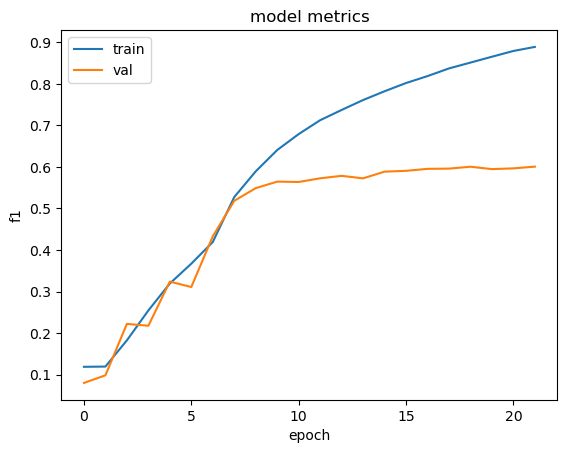

In [74]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model metrics')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()